In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.constraints import max_norm
from sklearn.model_selection import train_test_split


# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.12.0


# Loading Dataset

In [2]:
path = "/kaggle/input/animals10/raw-img"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [3]:
df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
21590,/kaggle/input/animals10/raw-img/cane/OIP-BUrN_...,cane,0
6337,/kaggle/input/animals10/raw-img/gatto/672.jpeg,gatto,5
6032,/kaggle/input/animals10/raw-img/gatto/1274.jpeg,gatto,5
22295,/kaggle/input/animals10/raw-img/cane/OIP-d81m3...,cane,0
20032,/kaggle/input/animals10/raw-img/cane/OIP-_dOYP...,cane,0
12065,/kaggle/input/animals10/raw-img/gallina/OIP-Th...,gallina,4
24262,/kaggle/input/animals10/raw-img/farfalla/OIP--...,farfalla,3
7979,/kaggle/input/animals10/raw-img/scoiattolo/OIP...,scoiattolo,9
11235,/kaggle/input/animals10/raw-img/gallina/OIP-3o...,gallina,4
3811,/kaggle/input/animals10/raw-img/pecora/OIP-Ax1...,pecora,7


In [4]:
print("Shape of the dataset: ", df.shape)
print("_______________________________________")
print("Number of null values: ")
print(df.isnull().sum())
print("_______________________________________")
print("Number of unique values: ")
print(df.nunique())

print("---------------------------------------")
print("Number of images per category : ")
print(df.labels.value_counts())  

Shape of the dataset:  (26179, 3)
_______________________________________
Number of null values: 
imgpath           0
labels            0
encoded_labels    0
dtype: int64
_______________________________________
Number of unique values: 
imgpath           26179
labels               10
encoded_labels       10
dtype: int64
---------------------------------------
Number of images per category : 
cane          4863
ragno         4821
gallina       3098
cavallo       2623
farfalla      2112
mucca         1866
scoiattolo    1862
pecora        1820
gatto         1668
elefante      1446
Name: labels, dtype: int64


# Split the Dataset into Train & Test

In [5]:
train_df, Temp_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.60 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath      labels
0  /kaggle/input/animals10/raw-img/elefante/OIP-0...    elefante
1  /kaggle/input/animals10/raw-img/farfalla/OIP-8...    farfalla
2  /kaggle/input/animals10/raw-img/farfalla/ea36b...    farfalla
3  /kaggle/input/animals10/raw-img/scoiattolo/OIP...  scoiattolo
4  /kaggle/input/animals10/raw-img/cane/OIP-g1Dxp...        cane
(20943, 3)
--------Validation----------
                                             imgpath    labels
0  /kaggle/input/animals10/raw-img/farfalla/OIP-c...  farfalla
1  /kaggle/input/animals10/raw-img/ragno/OIP-VV8_...     ragno
2  /kaggle/input/animals10/raw-img/ragno/OIP-Pqwb...     ragno
3  /kaggle/input/animals10/raw-img/pecora/e830b90...    pecora
4  /kaggle/input/animals10/raw-img/cane/OIP-1Ndw-...      cane
(3141, 3)
----------Test--------------
                                             imgpath    labels
0  /kaggle/input/animals10/raw-img/ragno/OIP-E0v9...     ragn

Show sample from data

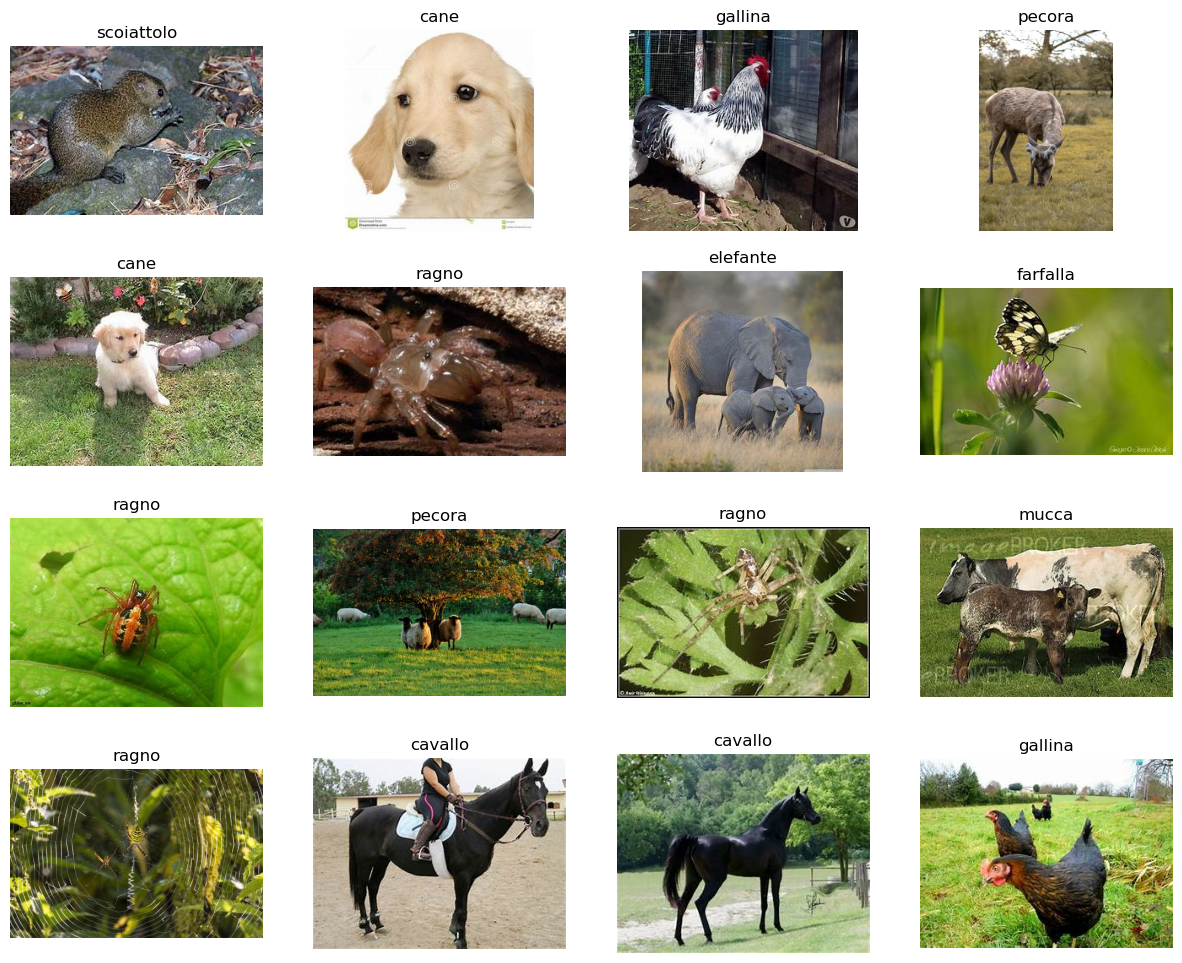

In [6]:
plt.figure(figsize=(12,9))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [7]:
%%time

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 20943 validated image filenames belonging to 10 classes.
Found 3141 validated image filenames belonging to 10 classes.
Found 2095 validated image filenames belonging to 10 classes.
CPU times: user 657 ms, sys: 791 ms, total: 1.45 s
Wall time: 1min 29s


# Model Structure

In [8]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

258076736/258076736 [==============================] - 2s 0us/step


In [9]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                               

# Training : Transfer Learning

In [10]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=75,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/75
655/655 [==============================] - 243s 323ms/step - loss: 1.5979 - accuracy: 0.5200 - val_loss: 0.3875 - val_accuracy: 0.9019 - lr: 1.0000e-05
Epoch 2/75
655/655 [==============================] - 133s 203ms/step - loss: 0.7527 - accuracy: 0.7680 - val_loss: 0.2300 - val_accuracy: 0.9433 - lr: 1.0000e-05
Epoch 3/75
655/655 [==============================] - 133s 203ms/step - loss: 0.5668 - accuracy: 0.8288 - val_loss: 0.1792 - val_accuracy: 0.9538 - lr: 1.0000e-05
Epoch 4/75
655/655 [==============================] - 133s 203ms/step - loss: 0.4811 - accuracy: 0.8528 - val_loss: 0.1564 - val_accuracy: 0.9583 - lr: 1.0000e-05
Epoch 5/75
655/655 [==============================] - 132s 202ms/step - loss: 0.4351 - accuracy: 0.8681 - val_loss: 0.1430 - val_accuracy: 0.9586 - lr: 1.0000e-05
Epoch 6/75
655/655 [==============================] - 133s 203ms/step - loss: 0.3987 - accuracy: 0.8776 - val_loss: 0.1367 - val_accuracy: 0.9621 - lr: 1.0000e-05
Epoch 7/75
655/655 [==

# Display model performance

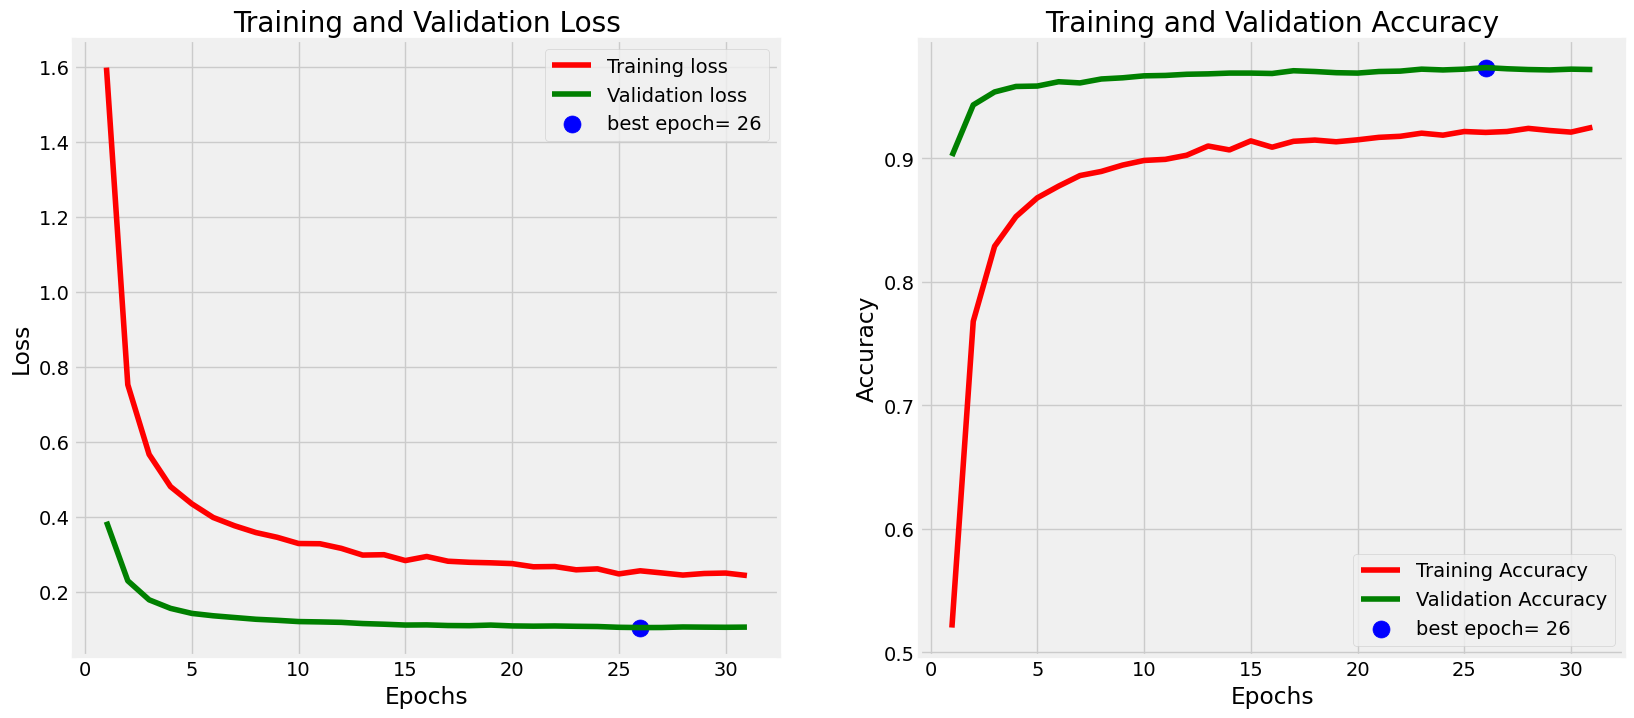

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Training : Fine Tuning

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=25,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 9,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 activation (Activation)     (None, 256)               0         
                       

# Display model performance

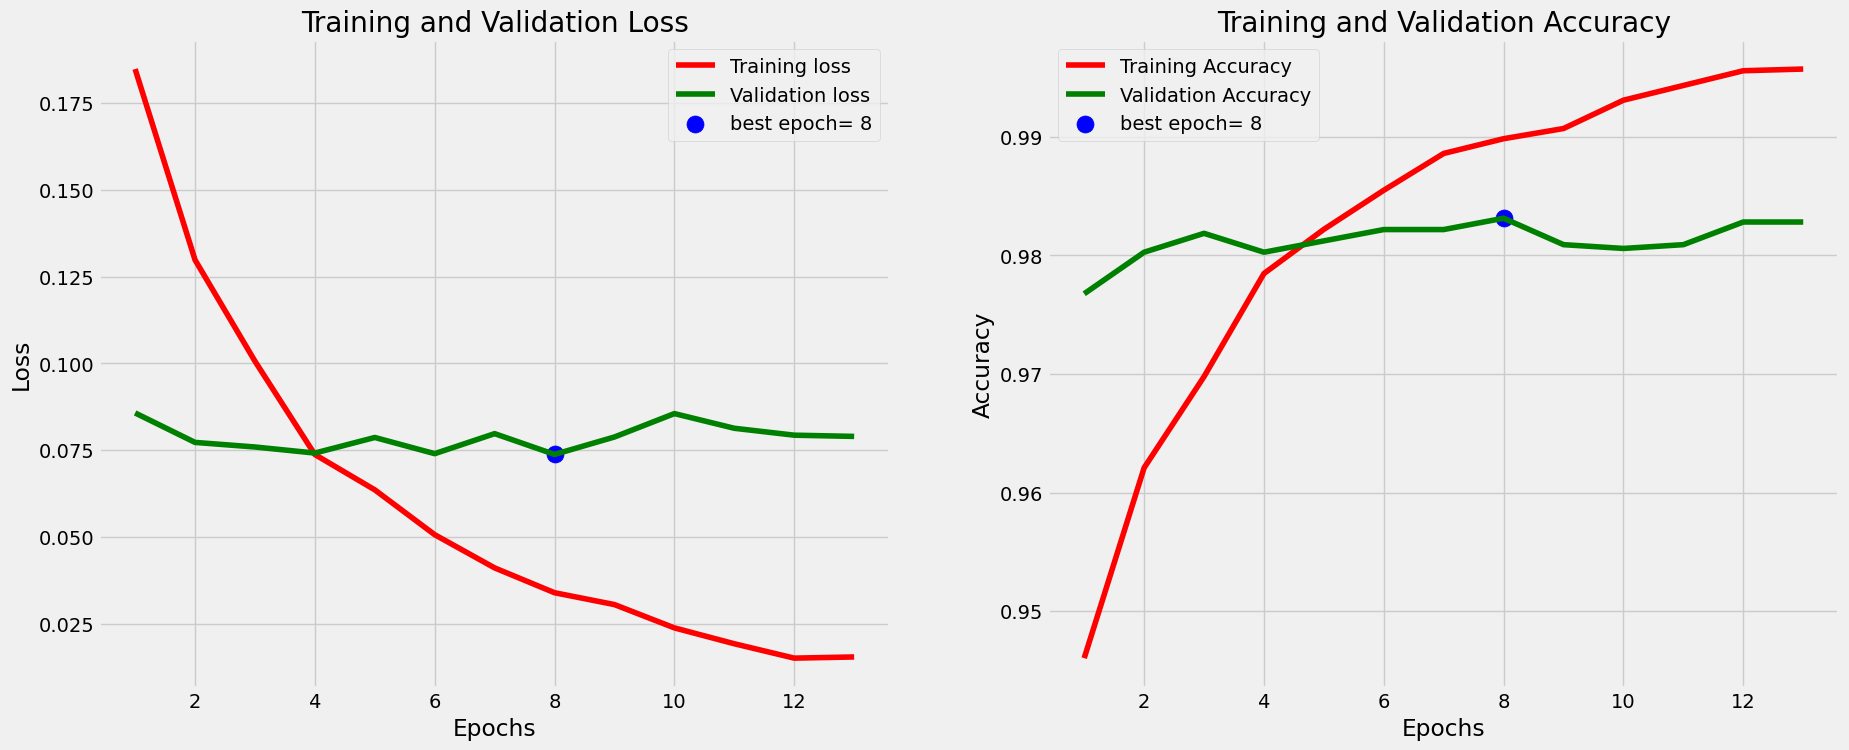

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


# model.evaluate

In [15]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06801
Test Accuracy: 98.52%


# F1 Score / Recall / Precision

In [16]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

66/66 [==============================] - 16s 163ms/step
F1 Score: 0.9833422338607521
              precision    recall  f1-score   support

        cane       0.97      0.99      0.98       367
     cavallo       0.97      0.98      0.98       221
    elefante       1.00      0.99      1.00       125
    farfalla       0.99      0.99      0.99       175
     gallina       1.00      1.00      1.00       236
       gatto       1.00      0.95      0.97       130
       mucca       0.97      0.97      0.97       144
      pecora       0.97      0.97      0.97       146
       ragno       1.00      1.00      1.00       414
  scoiattolo       0.99      0.99      0.99       137

    accuracy                           0.99      2095
   macro avg       0.99      0.98      0.98      2095
weighted avg       0.99      0.99      0.99      2095



# Confusion Matrix

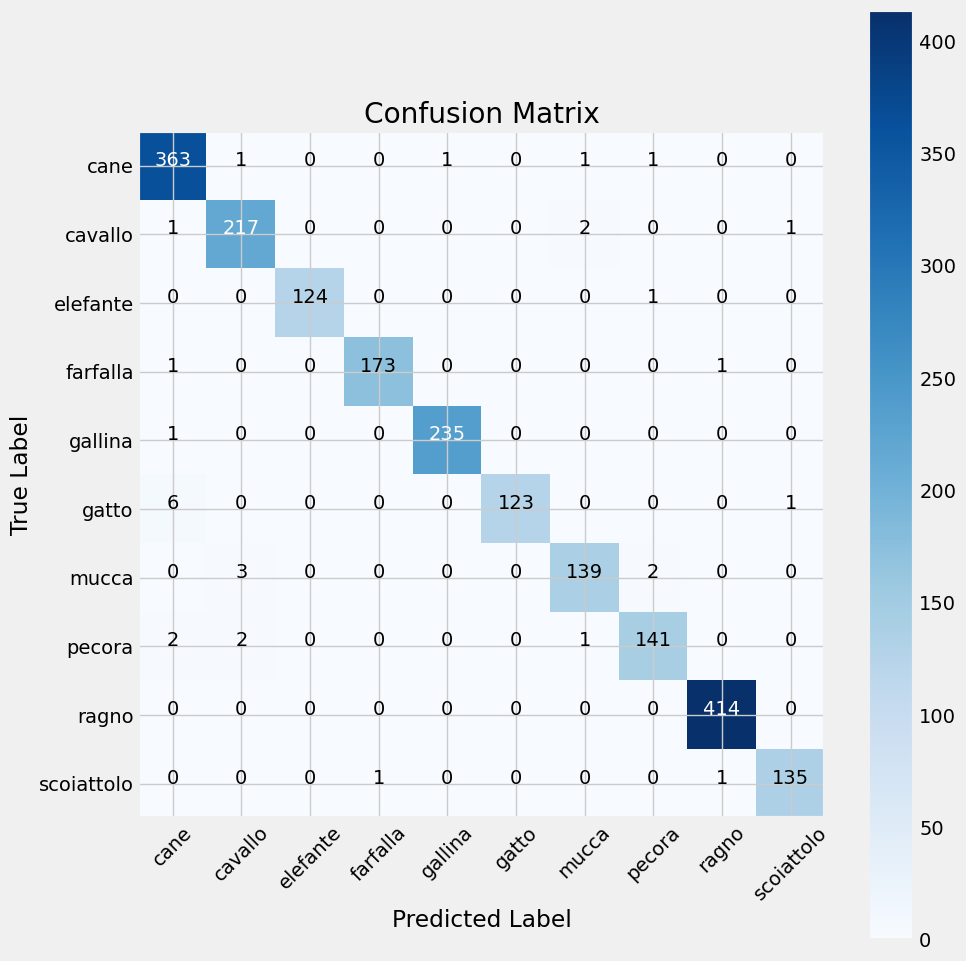

In [19]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()